In [1]:
import itertools as it
import logging
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from datasets import load_from_disk
from transformers import (
    BertForMaskedLM,
    BertForSequenceClassification,
    BertForTokenClassification,
)

import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from tqdm.auto import trange


import os
logger = logging.getLogger(__name__)

In [2]:

def gen_heatmap_class_colors(labels, df):
    pal = sns.cubehelix_palette(
        len(Counter(labels).keys()),
        light=0.9,
        dark=0.1,
        hue=1,
        reverse=True,
        start=1,
        rot=-2,
    )
    lut = dict(zip(map(str, Counter(labels).keys()), pal))
    colors = pd.Series(labels, index=df.index).map(lut)
    return colors


def gen_heatmap_class_dict(classes, label_colors_series):
    class_color_dict_df = pd.DataFrame(
        {"classes": classes, "color": label_colors_series}
    )
    class_color_dict_df = class_color_dict_df.drop_duplicates(subset=["classes"])
    return dict(zip(class_color_dict_df["classes"], class_color_dict_df["color"]))


def make_colorbar(embs_df, label):
    labels = list(embs_df[label])

    cell_type_colors = gen_heatmap_class_colors(labels, embs_df)
    label_colors = pd.DataFrame(cell_type_colors, columns=[label])

    # create dictionary for colors and classes
    label_color_dict = gen_heatmap_class_dict(labels, label_colors[label])
    return label_colors, label_color_dict

In [3]:
def plot_heatmap(embs_df, emb_dims, label, output_file, kwargs_dict):
    sns.set_style("white")
    sns.set(font_scale=2)
    plt.figure(figsize=(15, 15), dpi=150)
    label_colors, label_color_dict = make_colorbar(embs_df, label)

    default_kwargs_dict = {
        "row_cluster": True,
        "col_cluster": True,
        "row_colors": label_colors,
        "standard_scale": 1,
        "linewidths": 0,
        "xticklabels": False,
        "yticklabels": False,
        "figsize": (15, 15),
        "center": 0,
        "cmap": "magma",
    }

    if kwargs_dict is not None:
        default_kwargs_dict.update(kwargs_dict)
    g = sns.clustermap(
        embs_df.iloc[:, 0:emb_dims].apply(pd.to_numeric), **default_kwargs_dict
    )

    plt.setp(g.ax_row_colors.get_xmajorticklabels(), rotation=45, ha="right")

    for label_color in list(label_color_dict.keys()):
        g.ax_col_dendrogram.bar(
            0, 0, color=label_color_dict[label_color], label=label_color, linewidth=0
        )

        g.ax_col_dendrogram.legend(
            title=f"{label}",
            loc="lower center",
            ncol=4,
            bbox_to_anchor=(0.5, 1),
            facecolor="white",
        )
    plt.show()
    logger.info(f"Output file: {output_file}")
    plt.savefig(output_file, bbox_inches="tight")

In [4]:
def plot_umap(embs_df, emb_dims, label, output_file, kwargs_dict, seed=0):
    only_embs_df = embs_df.iloc[:, :emb_dims]
    only_embs_df.index = pd.RangeIndex(0, only_embs_df.shape[0], name=None).astype(str)
    only_embs_df.columns = pd.RangeIndex(0, only_embs_df.shape[1], name=None).astype(
        str
    )
    vars_dict = {"embs": only_embs_df.columns}
    obs_dict = {"cell_id": list(only_embs_df.index), f"{label}": list(embs_df[label])}
    adata = anndata.AnnData(X=only_embs_df, obs=obs_dict, var=vars_dict)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, random_state=seed)
    sc.tl.umap(adata, random_state=seed)
    sns.set(rc={"figure.figsize": (10, 10)}, font_scale=2.3)
    sns.set_style("white")
    default_kwargs_dict = {"size": 200}
    if kwargs_dict is not None:
        default_kwargs_dict.update(kwargs_dict)

    cats = set(embs_df[label])

    with plt.rc_context():
        ax = sc.pl.umap(adata, color=label, show=False, **default_kwargs_dict)
        ax.legend(
            markerscale=2,
            frameon=False,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            ncol=(1 if len(cats) <= 14 else 2 if len(cats) <= 30 else 3),
        )
        plt.show()
        plt.savefig(output_file, bbox_inches="tight")
        
def plot_embs(
    embs,
    plot_style,
    output_directory,
    output_prefix,
    max_ncells_to_plot=2000,
    kwargs_dict=None,
    ):
    """
    Plot embeddings, coloring by provided labels.

    **Parameters:**

    embs : pandas.core.frame.DataFrame
        | Pandas dataframe containing embeddings output from extract_embs
    plot_style : str
        | Style of plot: "heatmap" or "umap"
    output_directory : Path
        | Path to directory where plots will be saved as pdf
    output_prefix : str
        | Prefix for output file
    max_ncells_to_plot : None, int
        | Maximum number of cells to plot.
        | Default is 1000 cells randomly sampled from embeddings.
        | If None, will plot embeddings from all cells.
    kwargs_dict : dict
        | Dictionary of kwargs to pass to plotting function.

    **Examples:**

    .. code-block :: python

        >>> embex.plot_embs(embs=embs,
        ...         plot_style="heatmap",
        ...         output_directory="path/to/output_directory",
        ...         output_prefix="output_prefix")

    """

    embs = embs.sample(max_ncells_to_plot, axis=0)


    label_len = len(emb_labels)

    emb_dims = embs.shape[1] - label_len


    if plot_style == "umap":
        for label in emb_labels:
            output_prefix_label = output_prefix + f"_umap_{label}"
            output_file = (
                Path(output_directory) / output_prefix_label
            ).with_suffix(".pdf")
            plot_umap(embs, emb_dims, label, output_file, kwargs_dict)

    if plot_style == "heatmap":
        for label in emb_labels:
            output_prefix_label = output_prefix + f"_heatmap_{label}"
            output_file = (
                Path(output_directory) / output_prefix_label
            ).with_suffix(".pdf")
            plot_heatmap(embs, emb_dims, label, output_file, kwargs_dict)

def quant_layers(model):
    layer_nums = []
    for name, parameter in model.named_parameters():
        if "layer" in name:
            layer_nums += [int(name.split("layer.")[1].split(".")[0])]
    return int(max(layer_nums)) + 1




def pad_tensor(tensor, pad_token_id, max_len):
    tensor = torch.nn.functional.pad(
        tensor, pad=(0, max_len - tensor.numel()), mode="constant", value=pad_token_id
    )

    return tensor

def gen_attention_mask(minibatch_encoding, max_len=None):

    max_len = max(minibatch_encoding["length"])
    original_lens = minibatch_encoding["length"]
    attention_mask = [
        [1] * original_len + [0] * (max_len - original_len)
        if original_len <= max_len
        else [1] * max_len
        for original_len in original_lens
    ]
    return torch.tensor(attention_mask, device="cuda")

def mean_nonpadding_embs(embs, original_lens, dim=1):
    # create a mask tensor based on padding lengths
    mask = torch.arange(embs.size(dim), device=embs.device) < original_lens.unsqueeze(1)
    if embs.dim() == 3:
        # fill the masked positions in embs with zeros
        masked_embs = embs.masked_fill(~mask.unsqueeze(2), 0.0)

        # compute the mean across the non-padding dimensions
        mean_embs = masked_embs.sum(dim) / original_lens.view(-1, 1).float()

    elif embs.dim() == 2:
        masked_embs = embs.masked_fill(~mask, 0.0)
        mean_embs = masked_embs.sum(dim) / original_lens.float()
    return mean_embs
def pad_3d_tensor(tensor, pad_token_id, max_len, dim):
    if dim == 0:
        raise Exception("dim 0 usually does not need to be padded.")
    if dim == 1:
        pad = (0, 0, 0, max_len - tensor.size()[dim])
    elif dim == 2:
        pad = (0, max_len - tensor.size()[dim], 0, 0)
    tensor = torch.nn.functional.pad(
        tensor, pad=pad, mode="constant", value=pad_token_id
    )
    return tensor

def label_cell_embs(embs, downsampled_data, emb_labels):
    embs_df = pd.DataFrame(embs.cpu().numpy())
    if emb_labels is not None:
        for label in emb_labels:
            emb_label = downsampled_data[label]
            embs_df[label] = emb_label
    return embs_df

def label_gene_embs(embs, downsampled_data, token_gene_dict):
    gene_set = {
        element for sublist in downsampled_data["input_ids"] for element in sublist
    }
    gene_emb_dict = {k: [] for k in gene_set}
    for i in range(embs.size()[0]):
        length = downsampled_data[i]["length"]
        dict_i = dict(
            zip(
                downsampled_data[i]["input_ids"][0:length],
                embs[i, :, :].unsqueeze(dim=1),
            )
        )
        for k in dict_i.keys():
            gene_emb_dict[k].append(dict_i[k])
    for k in gene_emb_dict.keys():
        gene_emb_dict[k] = (
            torch.squeeze(torch.mean(torch.stack(gene_emb_dict[k]), dim=0), dim=0)
            .cpu()
            .numpy()
        )
    embs_df = pd.DataFrame(gene_emb_dict).T
    embs_df.index = [token_gene_dict[token] for token in embs_df.index]
    return embs_df

def pad_tensor_list(
    tensor_list,
    dynamic_or_constant,
    pad_token_id,
    model_input_size,
    dim=None,
    padding_func=None,
):
    # determine maximum tensor length
    if dynamic_or_constant == "dynamic":
        max_len = max([tensor.squeeze().numel() for tensor in tensor_list])
    else:
        max_len = dynamic_or_constant


    # pad all tensors to maximum length
    if dim is None:
        tensor_list = [
            pad_tensor(tensor, pad_token_id, max_len) for tensor in tensor_list
        ]
    else:
        tensor_list = [
            padding_func(tensor, pad_token_id, max_len, dim) for tensor in tensor_list
        ]
    # return stacked tensors
    if padding_func != pad_3d_tensor:
        return torch.stack(tensor_list)
    else:
        return torch.cat(tensor_list, 0)

In [5]:
emb_mode = "cell"
emb_labels=["cell_type"]

In [6]:
emb_layer=-1
forward_batch_size=20

In [7]:
token_dictionary_file=os.path.join(os.getcwd(), '../geneformer/token_dictionary_gc95M.pkl')

with open(token_dictionary_file, "rb") as f:
    gene_token_dict = pickle.load(f)

token_gene_dict = {v: k for k, v in gene_token_dict.items()}
pad_token_id = gene_token_dict.get("<pad>")

In [8]:
input_data_file=os.path.join(os.getcwd(), 'endo_gex_tokens/endo.dataset')
data = load_from_disk(input_data_file)

# sort dataset with largest cell first to encounter any memory errors earlier
data = data.sort("length", reverse=True)

In [9]:
model_directory=os.path.join(os.getcwd(), '../gf-12L-95M-i4096') 
cls_present=True
eos_present=True
model_type="Pretrained"
output_hidden_states = True

# Model class selection
model_classes = {
    "Pretrained": BertForMaskedLM,
    "GeneClassifier": BertForTokenClassification,
    "CellClassifier": BertForSequenceClassification,
    "MTLCellClassifier": BertForMaskedLM}

model_class = model_classes.get(model_type)

# Model loading
model_args = {
    "pretrained_model_name_or_path": model_directory,
    "output_hidden_states": output_hidden_states,
    "output_attentions": False}


# Load the model
model = model_class.from_pretrained(**model_args)
model.eval()



layer_to_quant = quant_layers(model) + emb_layer
total_batch_length = len(data)
model_input_size=model.config.max_position_embeddings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)




embs_list=[]
overall_max_len=0
for i in trange(0, total_batch_length, forward_batch_size, leave=True):
        max_range = min(i + forward_batch_size, total_batch_length)

        minibatch = data.select([i for i in range(i, max_range)])

        max_len = int(max(minibatch["length"]))
        original_lens = torch.tensor(minibatch["length"], device="cuda")
        minibatch.set_format(type="torch")

        input_data_minibatch = minibatch["input_ids"]
        input_data_minibatch = pad_tensor_list(
            input_data_minibatch, max_len, pad_token_id, model_input_size
        )        

        with torch.no_grad():
            outputs = model(
                input_ids=input_data_minibatch.to("cuda"),
                attention_mask=gen_attention_mask(minibatch),
            )

        embs_i = outputs.hidden_states[layer_to_quant]

        if emb_mode == "cell":
            non_cls_embs = embs_i[:, 1:, :]  # Get all layers except the embs
            mean_embs = mean_nonpadding_embs(non_cls_embs, original_lens - 2)
            embs_list.append(mean_embs)
            del mean_embs
        elif emb_mode == "gene":
            embs_list.append(embs_i)
        elif emb_mode == "cls":
            cls_embs = embs_i[:, 0, :].clone().detach()  # CLS token layer
            embs_list.append(cls_embs)
            del cls_embs

        overall_max_len = max(overall_max_len, max_len)
        del outputs
        del minibatch
        del input_data_minibatch
        del embs_i

        torch.cuda.empty_cache() 

  0%|          | 0/3660 [00:00<?, ?it/s]

In [10]:
if (emb_mode == "cell") or (emb_mode == "cls"):
    embs_stack = torch.cat(embs_list, dim=0)
elif emb_mode == "gene":
    embs_stack = pad_tensor_list(
    embs_list,
    overall_max_len,
    pad_token_id,
    model_input_size,
    1,
    pad_3d_tensor)    


if emb_mode == "cell":
    embs_df = label_cell_embs(embs_stack, data, emb_labels)
elif emb_mode == "gene":
    embs_df = label_gene_embs(embs_stack, data, token_gene_dict)
elif emb_mode == "cls":
    embs_df = label_cell_embs(embs_stack, data, emb_labels)              

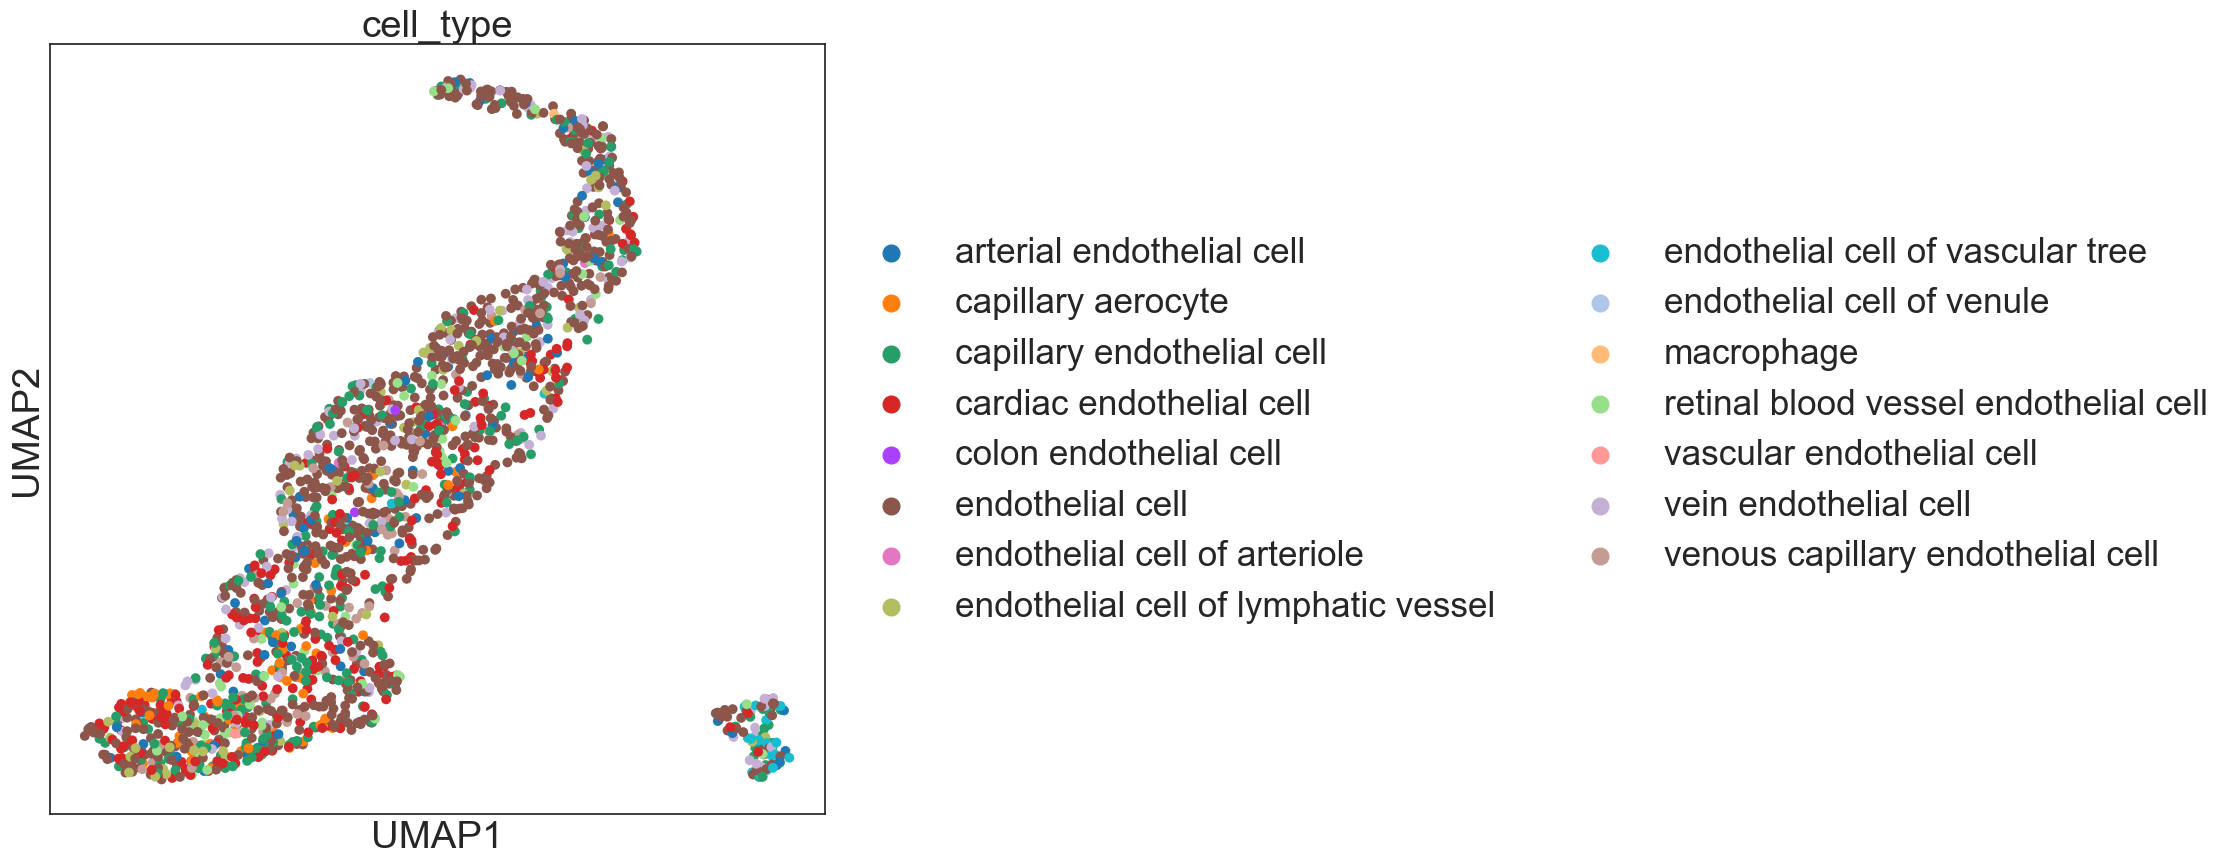

In [12]:
                

# plot UMAP of cell embeddings
# note: scanpy umap necessarily saves figs to figures directory
plot_embs(embs=embs_df, 
                plot_style="umap",
                output_directory="../test_output_directory/",  
                output_prefix="emb_plot")

C:\Users\zainsamadi\pyprojects\Geneformer\gnformer\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\zainsamadi\pyprojects\Geneformer\gnformer\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1000 with 0 Axes>

<Figure size 2250x2250 with 0 Axes>

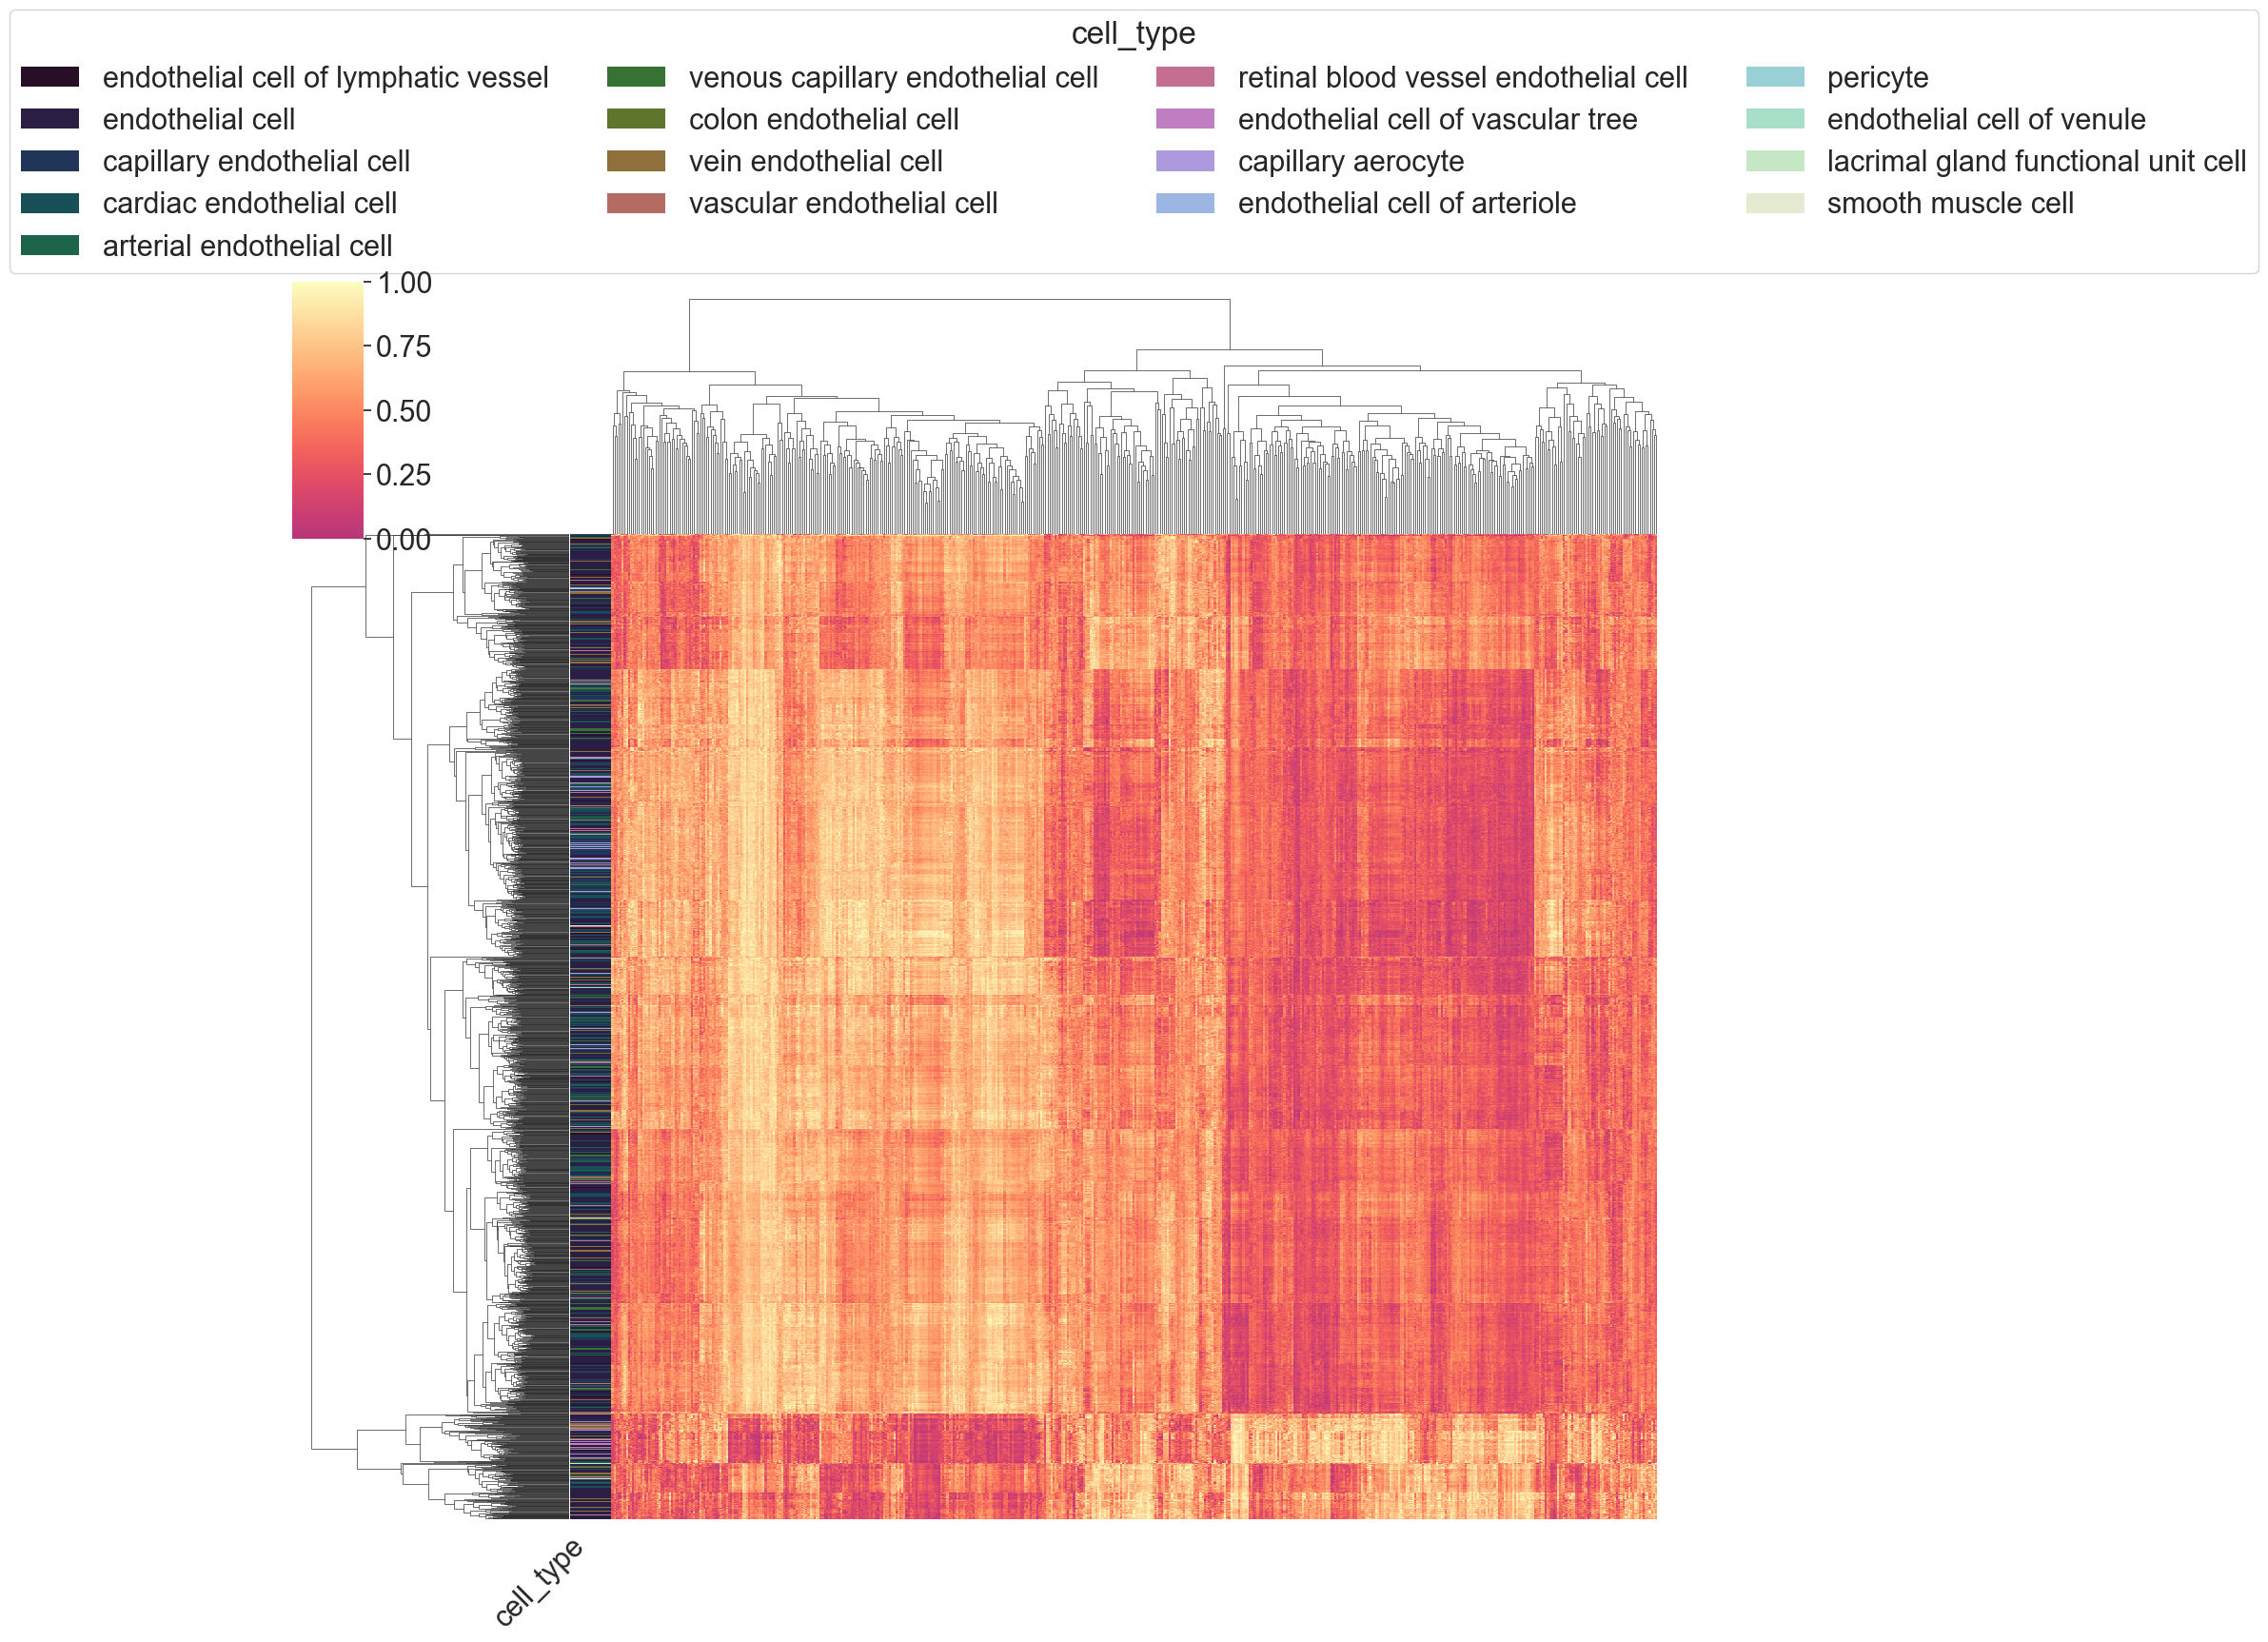

In [13]:
# plot heatmap of cell embeddings
plot_embs(embs=embs_df, 
                plot_style="heatmap",
                output_directory="../test_output_directory/",
                output_prefix="emb_plot")



check=1